In [1]:
# Links úteis
# https://www.youtube.com/watch?v=5vrY4RbeWkM
# anomaly detection - Andrew ng - multivariated distribuctions - https://www.youtube.com/watch?v=YRS-IB3vCow
# https://www.kaggle.com/clemensmzr/simple-multivariate-gaussian-anomaly-detection

In [45]:
# Imports

import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import scipy
from random import shuffle
from time import time
import pickle 
from tqdm import tqdm
from scipy import stats

# sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import fbeta_score
        
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [48]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

def f1_treshold(y_test, y_pred, range_, min_, max_):
    valores_f1 = []
    #valores_cm = []
    passo = [x for x in frange(min_, max_, range_)]

    for i in passo:
        y_pred_ = np.where(y_pred < i , 0, 1)
        valores_f1.append(f1_score(y_test, y_pred_))
        
    sns.set_style("darkgrid")    
    plt.figure(figsize=(15,5)) 
    plt.title('Sensibilidade do treshold no F1 Score', fontsize = 20)
    plt.ylabel('F1 Score', fontsize = 20)
    plt.xlabel('Treshold', fontsize = 20)
    plt.tick_params(labelsize=15)

    plt.plot(passo, valores_f1)
    plt.axvline(x=passo[valores_f1.index(max(valores_f1))],  color = 'green', ls = '--' )
    plt.ylim((0, 1))
    plt.xlim((min_, max_))

    plt.legend(['F1 Score', 'Melhor treshold'], loc='upper right', fontsize= 20)

    plt.show()

    print('valor máximo de F1: %.3f%%' % (max(valores_f1)*100))
    
    return passo[valores_f1.index(max(valores_f1))]


In [4]:
glob('data/*')

['data\\satellite-unsupervised-ad.csv']

In [5]:
df = pd.read_csv('data\\satellite-unsupervised-ad.csv', names = ['v'+ str(n) for n in range(36)]+['anomaly'])
df.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v27,v28,v29,v30,v31,v32,v33,v34,v35,anomaly
0,46.0,40.0,119.0,139.0,42.0,30.0,135.0,157.0,42.0,30.0,...,113.0,50.0,46.0,111.0,116.0,44.0,31.0,131.0,142.0,o
1,47.0,37.0,119.0,133.0,44.0,34.0,124.0,143.0,44.0,34.0,...,85.0,50.0,39.0,118.0,132.0,43.0,29.0,133.0,143.0,o
2,80.0,95.0,100.0,74.0,64.0,64.0,104.0,96.0,46.0,36.0,...,81.0,82.0,91.0,92.0,78.0,78.0,83.0,96.0,74.0,o
3,56.0,51.0,72.0,60.0,59.0,54.0,72.0,60.0,59.0,51.0,...,50.0,57.0,55.0,74.0,61.0,57.0,55.0,78.0,65.0,o
4,44.0,34.0,129.0,140.0,44.0,34.0,124.0,136.0,44.0,34.0,...,139.0,43.0,31.0,128.0,135.0,43.0,29.0,128.0,132.0,o


In [6]:
df['anomaly'].value_counts()

n    5025
o      75
Name: anomaly, dtype: int64

In [7]:
len(df)

5100

In [8]:
df_n = df[df['anomaly'] == 'n'].copy()
df_o = df[df['anomaly'] == 'o'].copy()

# Dataframe original

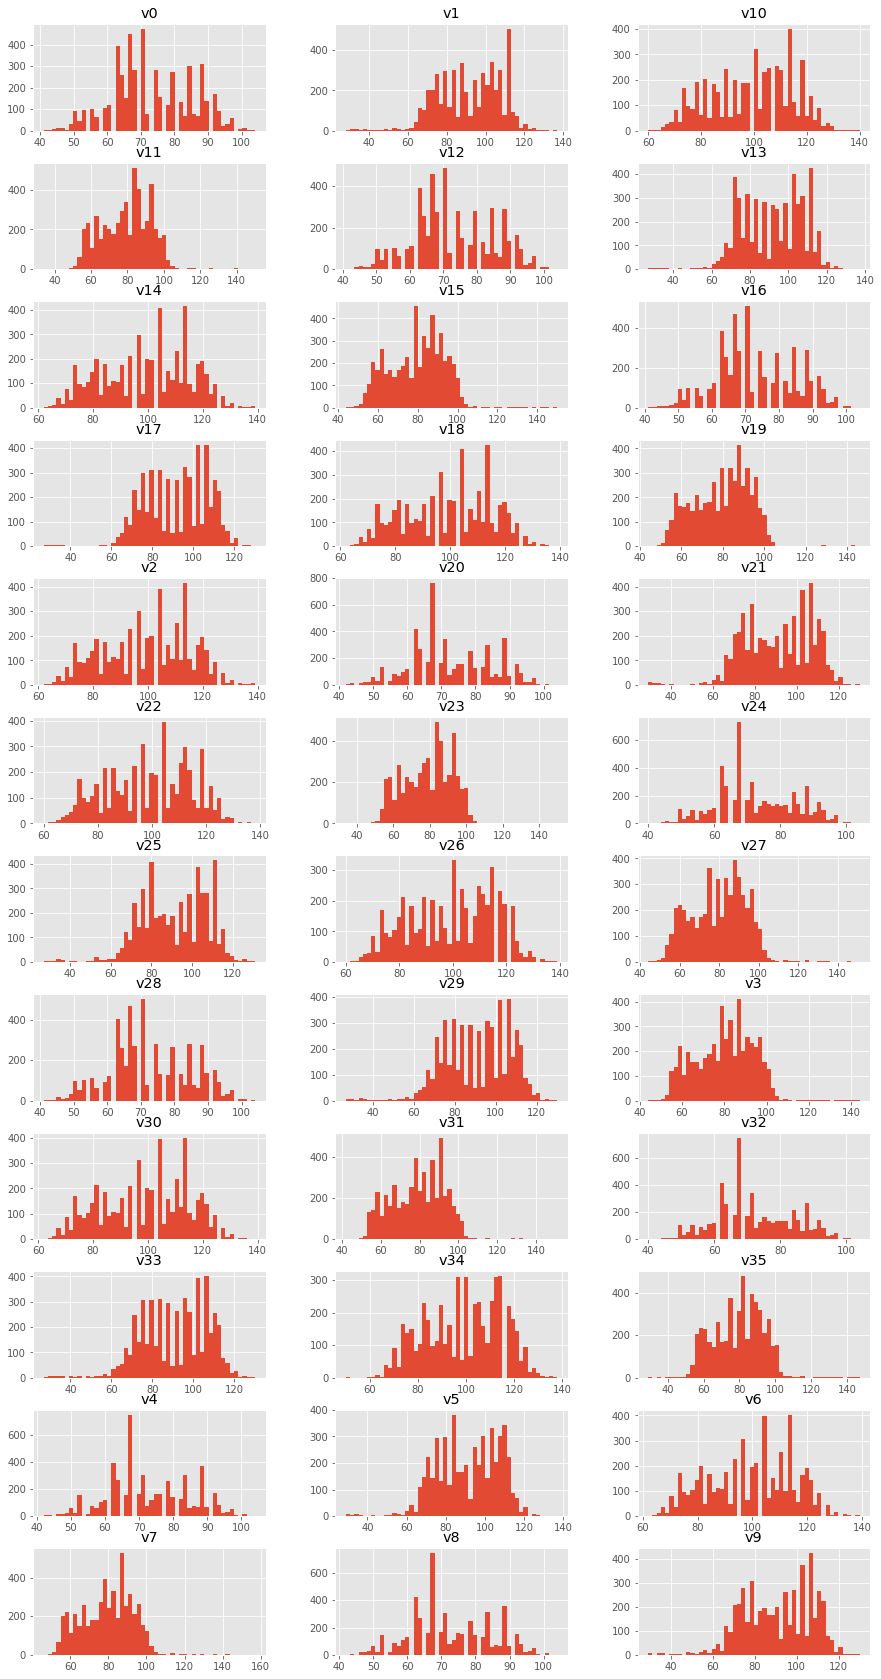

In [9]:
# Plota os histogramas das variáveis
matplotlib.style.use('ggplot')
df.hist(stacked=False, bins=50, figsize=(15,30), layout=(12,3))
plt.show()

In [10]:
#list(enumerate(df.drop('anomaly', axis = 1).columns))

C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


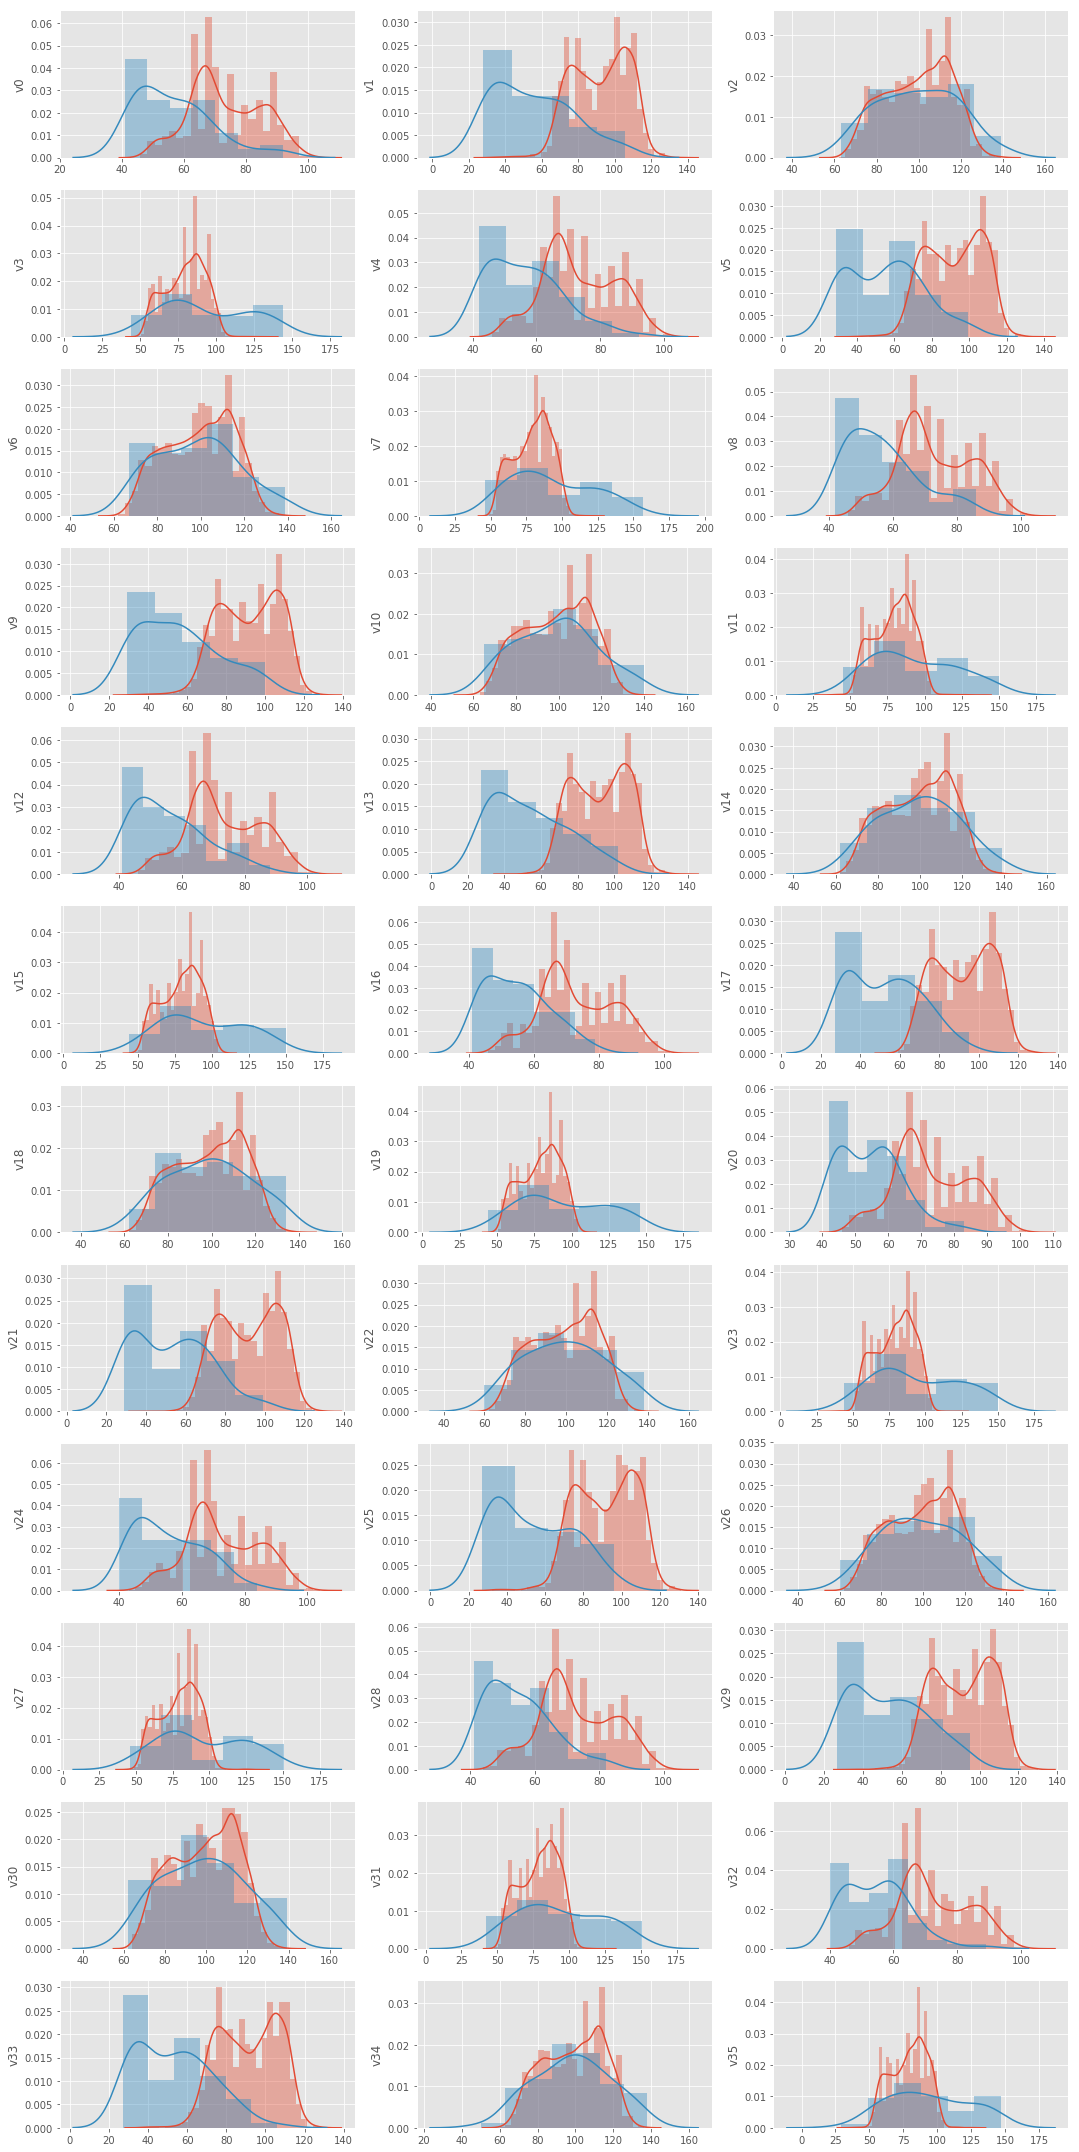

In [11]:
# Plota os histogramas diferenciando outliers de dados normais
fig, axes = plt.subplots(nrows=12, ncols=3, figsize=(15, 30))
for idx, feat in enumerate(df.drop('anomaly', axis = 1).columns):
    ax = axes[int(idx / 3), idx % 3]
    sns.distplot(df_n[feat],ax=ax)
    sns.distplot(df_o[feat], ax=ax)

    ax.set_xlabel('')
    ax.set_ylabel(feat)
fig.tight_layout();

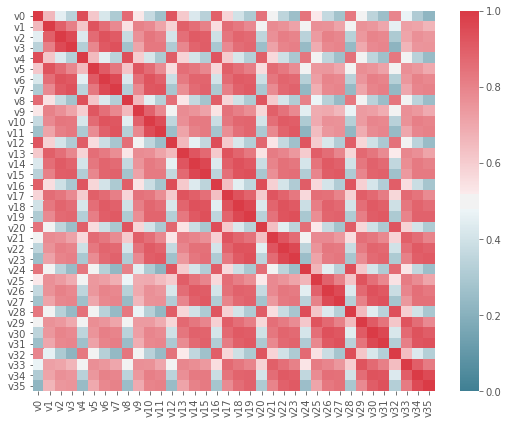

In [12]:
# Correlações entre features
plt.figure(figsize=(9,7))
sns.heatmap(df_n.corr(), cmap = sns.diverging_palette(220, 10, as_cmap=True), vmax = 1, vmin = -0)

In [13]:
var_cols = df_n.drop('anomaly', axis =1).columns
var_cols

Index(['v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30',
       'v31', 'v32', 'v33', 'v34', 'v35'],
      dtype='object')

# Dataframe normalizado

In [14]:
df_norm = pd.DataFrame()
for col in var_cols:
    df_norm[col+'_norm'] = (df[col] - df[col].mean())/df[col].std()
    
df_norm['anomaly_norm'] = df['anomaly']

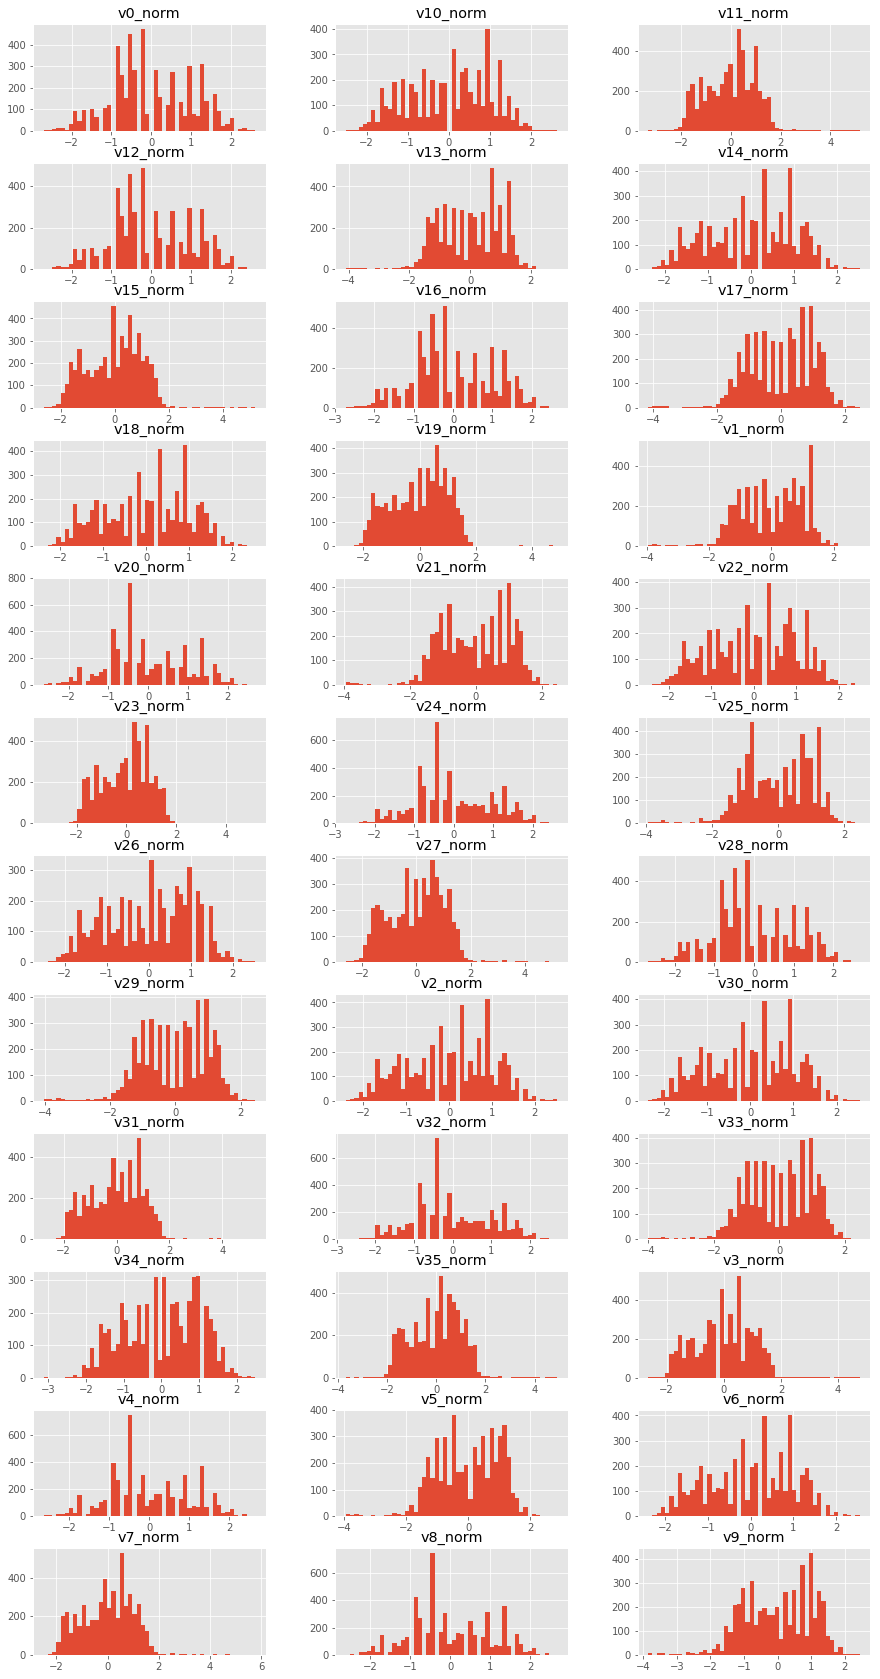

In [15]:
matplotlib.style.use('ggplot')
df_norm.hist(stacked=False, bins=50, figsize=(15,30), layout=(12,3))
plt.show()

In [17]:
df_norm_n = df_norm[df_norm['anomaly_norm'] == 'n'].copy()
df_norm_o = df_norm[df_norm['anomaly_norm'] == 'o'].copy()

C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


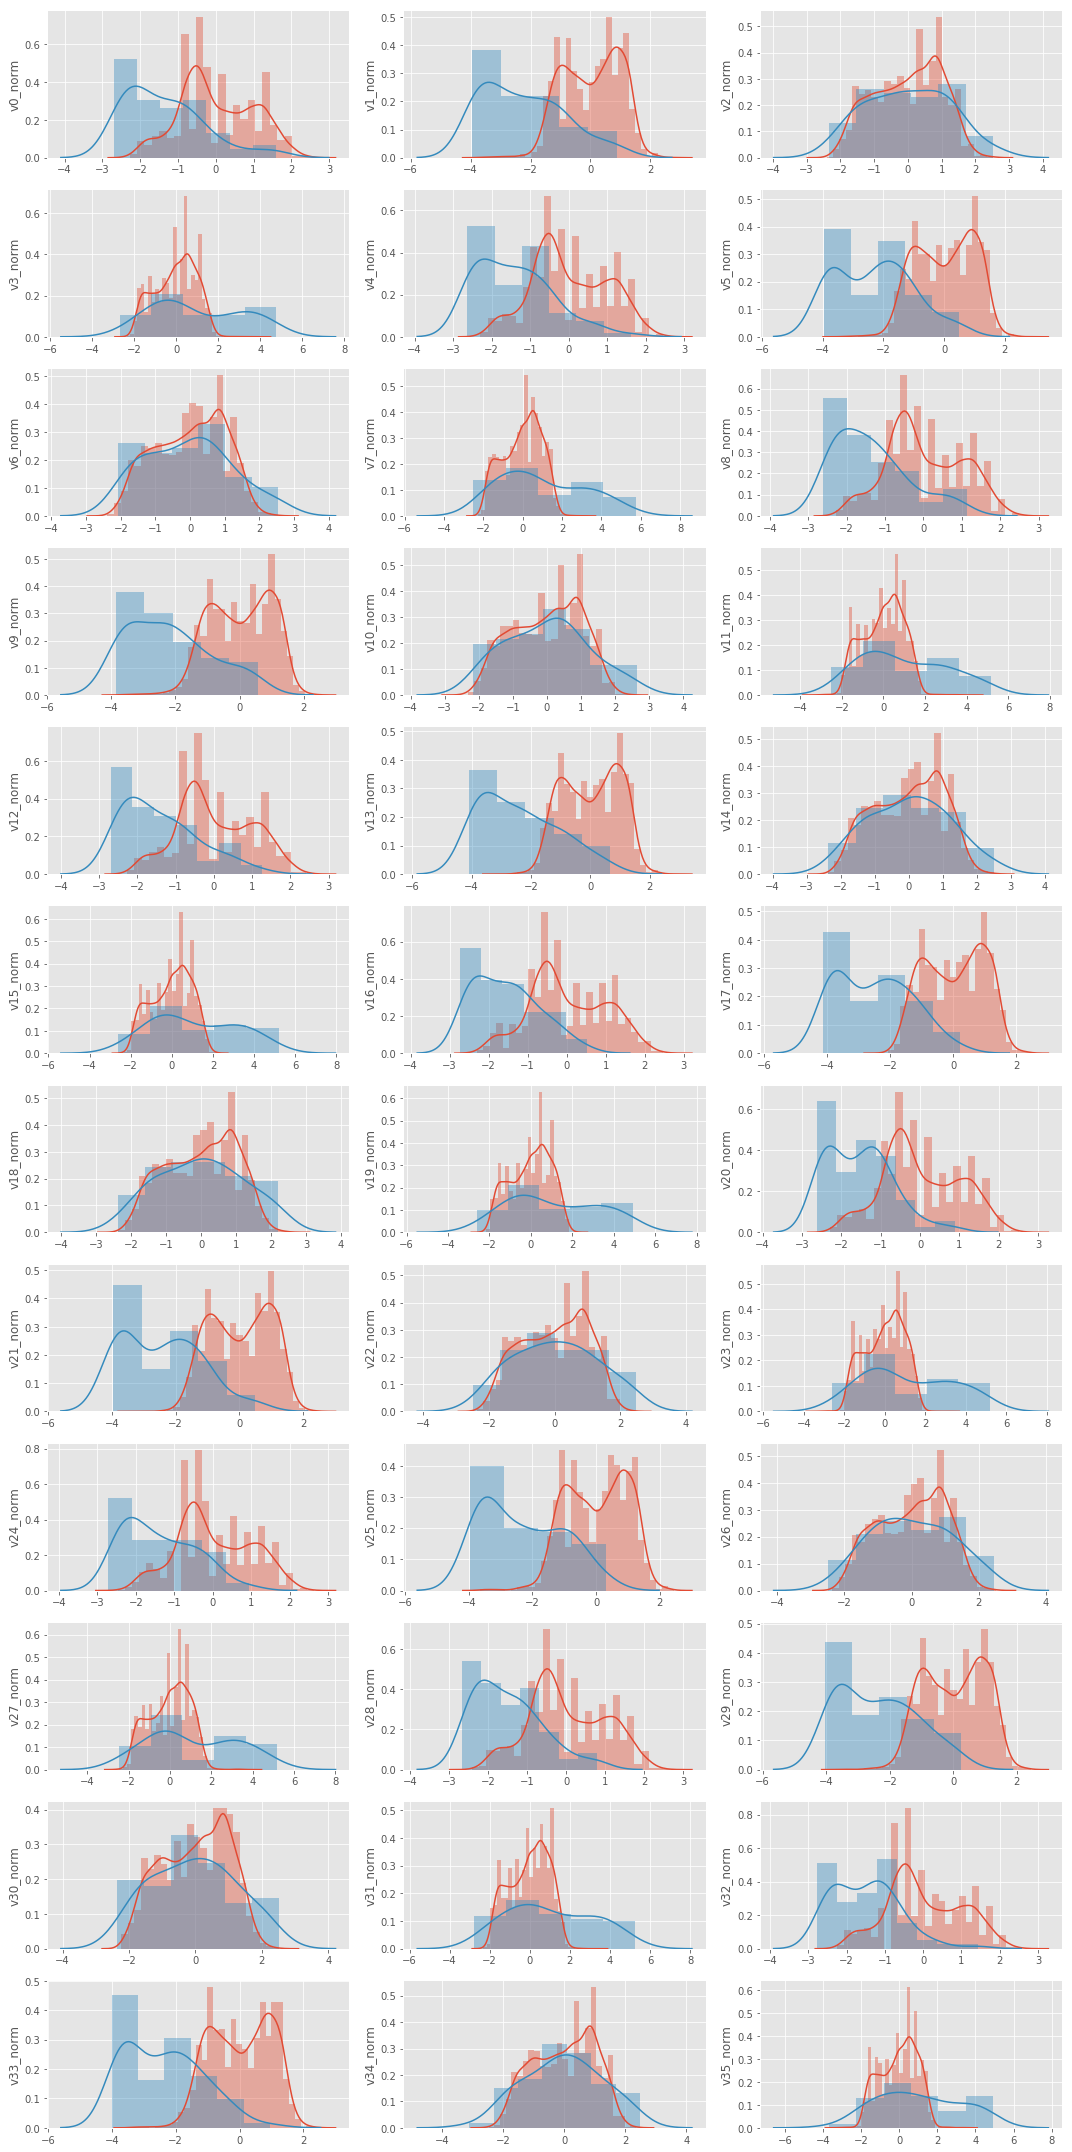

In [19]:
fig, axes = plt.subplots(nrows=12, ncols=3, figsize=(15, 30))
for idx, feat in enumerate(var_cols + '_norm'):
    ax = axes[int(idx / 3), idx % 3]
    sns.distplot(df_norm_n[feat],ax=ax)
    sns.distplot(df_norm_o[feat], ax=ax)

    ax.set_xlabel('')
    ax.set_ylabel(feat)
fig.tight_layout();

# PCA

In [21]:
pca = PCA(n_components=5)
resp = pca.fit_transform(df.drop('anomaly', axis = 1))

print('Variância explicada para cada dimensão',pca.explained_variance_ratio_)  
print('Variância acumulada                   ',pca.explained_variance_ratio_.cumsum())

Variância explicada para cada dimensão [0.69966203 0.1462607  0.03841081 0.0305519  0.02732196]
Variância acumulada                    [0.69966203 0.84592273 0.88433354 0.91488544 0.9422074 ]


In [22]:
df_pca = pd.DataFrame(resp, columns = ['pca_'+str(i+1)for i in range(len(pca.explained_variance_ratio_))])
df_pca['label'] = df['anomaly']

df_pca.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,label
0,-8.542138,213.137134,-5.958652,153.214318,-18.790943,o
1,-4.592625,191.214075,5.754867,143.892392,-11.843633,o
2,6.848358,31.270471,8.740949,42.169283,14.349787,o
3,159.268066,19.067529,7.230918,15.679323,-7.449167,o
4,-7.261953,224.101855,9.959655,161.953924,4.499826,o


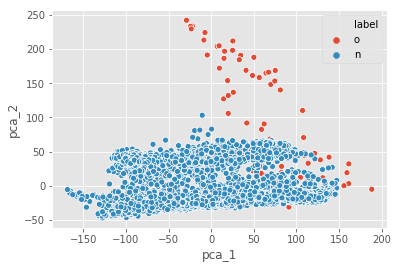

In [23]:
# plota os dois primeiros componentes principais 
sns.scatterplot(x="pca_1", y="pca_2", data=df_pca, hue = 'label')

C:\Users\guilherme.bonaldo\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


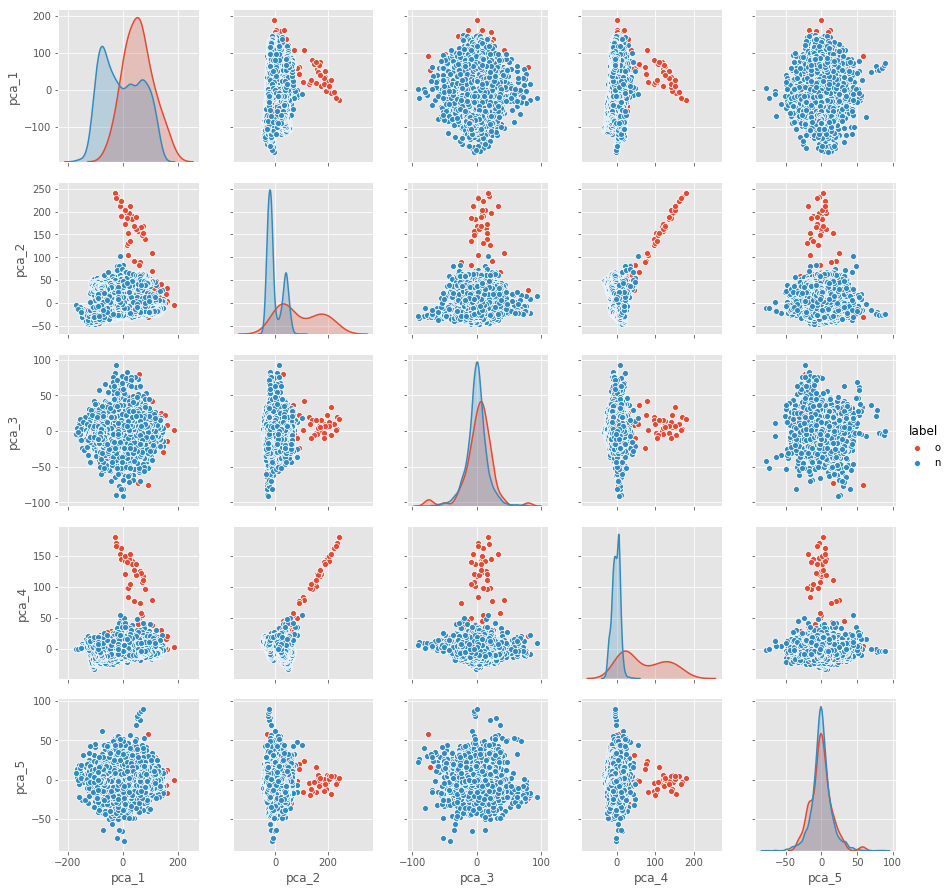

In [24]:
# plota todos os componenetes princiapais
sns.pairplot(df_pca, hue="label")

# Algoritmos

Temos 3 datasets:
- original
- normalizado
- PCA

A ideia é ajustar modelo para os três e ver qual tem os melhores resultados

Mesmo não sendo outlier em uma distribuição, ao se combinar n distribuições pode se tornar um, devido ao fato de existir covariância entre as distribuições.

## Dataframe original

In [25]:
df.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v27,v28,v29,v30,v31,v32,v33,v34,v35,anomaly
0,46.0,40.0,119.0,139.0,42.0,30.0,135.0,157.0,42.0,30.0,...,113.0,50.0,46.0,111.0,116.0,44.0,31.0,131.0,142.0,o
1,47.0,37.0,119.0,133.0,44.0,34.0,124.0,143.0,44.0,34.0,...,85.0,50.0,39.0,118.0,132.0,43.0,29.0,133.0,143.0,o
2,80.0,95.0,100.0,74.0,64.0,64.0,104.0,96.0,46.0,36.0,...,81.0,82.0,91.0,92.0,78.0,78.0,83.0,96.0,74.0,o
3,56.0,51.0,72.0,60.0,59.0,54.0,72.0,60.0,59.0,51.0,...,50.0,57.0,55.0,74.0,61.0,57.0,55.0,78.0,65.0,o
4,44.0,34.0,129.0,140.0,44.0,34.0,124.0,136.0,44.0,34.0,...,139.0,43.0,31.0,128.0,135.0,43.0,29.0,128.0,132.0,o


In [26]:
# No dataset de treino, não existem outliers
X_train = df[var_cols][1000:]
X_test = df[var_cols][:1000]

In [27]:
X_train.shape

(4100, 36)

In [28]:
# econtra os parametros de variancia e média para a gaussiana multivariada
sigma = np.cov(X_train, rowvar = False)
#cov_i = np.linalg.pinv(cov)
sigma_i = np.linalg.inv(sigma)
#cov_d = np.linalg.det(cov)
mean = np.mean(X_train, axis=0)

In [29]:
# calcula a probabilidade de um ponto pertencer à distribuição
def prob_multi(x, mean, sigma, sigma_i, var_cols):
    m_dist_x = np.dot((x-mean).T,sigma_i)
    m_dist_x = np.dot(m_dist_x, (x-mean))
    return 1-stats.chi2.cdf(m_dist_x, len(var_cols))

In [33]:
probs = []
for index, row in X_test.iterrows():
    #print (row)
    probs.append((df['anomaly'][index],prob_multi(row,mean, sigma, sigma_i, var_cols)))

In [35]:
df_gauss = pd.DataFrame(probs, columns = ['label', 'value'])
df_gauss.head(10)

,label,value
0,o,0.000000
1,o,0.000000
2,o,0.000000
3,o,0.003013
4,o,0.000000
5,o,0.000000
6,o,0.009642
7,o,0.000000
8,o,0.000000
9,o,0.021361


In [121]:
#np.exp( -0.5* np.dot(np.dot((x-mean).T,cov_i), (x-mean))  ) /((2. * np.pi)**(n/2.))/np.sqrt(cov_d))

In [122]:
#def prob_multi(x, cov, mean, cov_i, cov_d):
 #   n = len(cov)
 #   return np.exp( -0.5* np.dot(np.dot((x-mean).T,cov_i), (x-mean))  ) /(((2 * np.pi)**(n/2.)) * np.sqrt(cov_d))

In [36]:
# Estatísticas das probabilidades dos outliers
df_gauss[df_gauss['label'] == 'o'].describe()

,value
count,75.000000
mean,0.053856
std,0.174934
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000215
max,0.852622


In [37]:
# Estatísticas das probabilidades dos dados normais
df_gauss[df_gauss['label'] == 'n'].describe()

,value
count,925.000000
mean,0.703493
std,0.322032
min,0.000000
25%,0.538409
50%,0.849622
75%,0.964326
max,0.999999


In [38]:
np.percentile(df_gauss[df_gauss['label'] == 'n']['value'], [5,10,20,30])

array([0.00933867, 0.1151944 , 0.37278452, 0.62030454])

In [39]:
np.percentile(df_gauss[df_gauss['label'] == 'o']['value'], [50,60,75,80,90,95])

array([0.00000000e+00, 2.28656429e-09, 2.15072462e-04, 4.33887884e-03,
       1.07381081e-01, 4.23342557e-01])

[Text(0,0.5,'Frequencia'), Text(0.5,0,'probabilidade')]

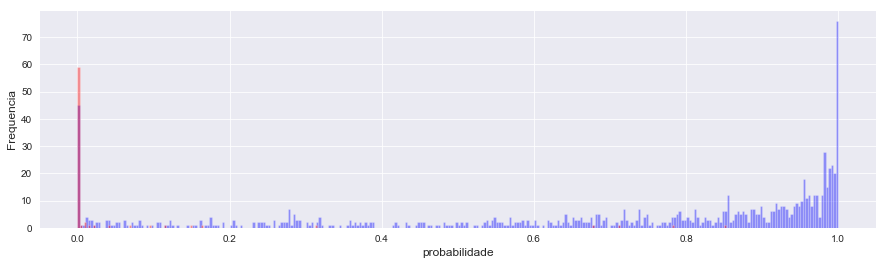

In [102]:
fig = plt.figure(figsize=(15,4),)
ax=sns.distplot(df_gauss.loc[(df_gauss['label'] == 'n'),'value'] , color='b',label='normal', kde = False,  bins = 300)
ax=sns.distplot(df_gauss.loc[(df_gauss['label'] == 'o'),'value'] , color='r', label='outlier', kde = False,  bins = 300)
ax.set(xlabel='probabilidade', ylabel='Frequencia')
#ax.set_xlim(0,0.01)

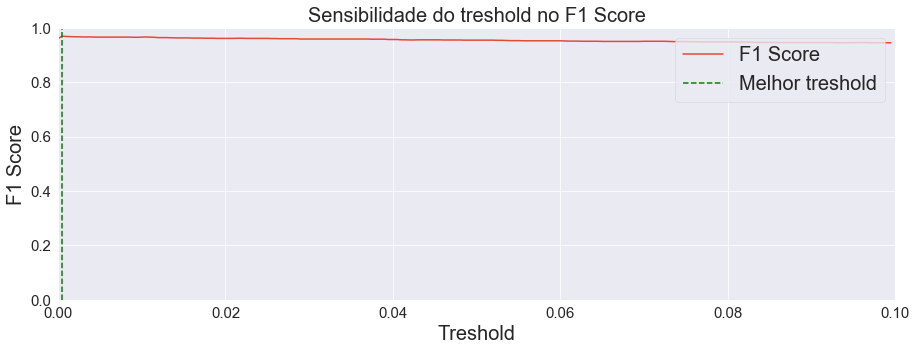

valor máximo de F1: 96.996%


0.0005

In [49]:
f1_treshold(np.where(df_gauss['label'] == 'o' , 0, 1), df_gauss['value'], 0.0005, min_ = 0, max_ = 0.1)

In [50]:
# se o evento tem probabilidade menor que 0.2% de acontecer, é uma falha
df_gauss['pred'] = np.where(df_gauss['value'] < 0.0005 , 0, 1)
#df_gauss['label'] = np.where(df_gauss['label'] == 'o' , 0, 1)

In [85]:
C_orig = confusion_matrix(np.where(df_gauss['label'] == 'o' , 0, 1), df_gauss['pred'])
f1_orig = f1_score(np.where(df_gauss['label'] == 'o' , 0, 1), df_gauss['pred'] )
print (C_orig)
print('')
print('F1 score:', f1_orig )

[[ 65  10]
 [ 62 863]]

F1 score: 0.9699617695248498


## PCA

In [53]:
df_pca.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,label
0,-8.542138,213.137134,-5.958652,153.214318,-18.790943,o
1,-4.592625,191.214075,5.754867,143.892392,-11.843633,o
2,6.848358,31.270471,8.740949,42.169283,14.349787,o
3,159.268066,19.067529,7.230918,15.679323,-7.449167,o
4,-7.261953,224.101855,9.959655,161.953924,4.499826,o


In [54]:
X_train_pca = df_pca[['pca_1','pca_2','pca_3','pca_4','pca_5']][1000:]
X_test_pca  = df_pca[['pca_1','pca_2','pca_3','pca_4','pca_5']][:1000]

print(X_train_pca.shape)
print(X_test_pca.shape)

(4100, 5)
(1000, 5)


In [55]:
sigma_pca  = np.cov(X_train_pca , rowvar = False)
#cov_i = np.linalg.pinv(cov)
sigma_i_pca  = np.linalg.inv(sigma_pca )
#cov_d = np.linalg.det(cov)
mean_pca  = np.mean(X_train_pca , axis=0)

print(sigma_pca.shape)
print(sigma_i_pca.shape)
print(mean_pca.shape)

(5, 5)
(5, 5)
(5,)


In [56]:
probs_pca = []
for index, row in X_test_pca.iterrows():
    #print (row)
    probs_pca.append((df_pca['label'][index],
                      prob_multi(row, mean_pca, sigma_pca, sigma_i_pca, var_cols =  ['pca_1','pca_2','pca_3','pca_4','pca_5'])))

df_gauss_pca = pd.DataFrame(probs_pca, columns = ['label', 'value'])
df_gauss_pca.head(5)

,label,value
0,o,0.000000
1,o,0.000000
2,o,0.000003
3,o,0.033881
4,o,0.000000


In [57]:
df_gauss_pca[df_gauss_pca['label'] == 'o'].describe()

,value
count,7.500000e+01
mean,2.430320e-02
std,5.369756e-02
min,0.000000e+00
25%,0.000000e+00
50%,7.883642e-09
75%,7.660701e-03
max,2.076640e-01


In [58]:
df_gauss_pca[df_gauss_pca['label'] == 'n'].describe()

,value
count,9.250000e+02
mean,5.767657e-01
std,2.698152e-01
min,2.834195e-08
25%,4.026227e-01
50%,6.100205e-01
75%,7.930781e-01
max,9.939670e-01


In [59]:
print(np.percentile(df_gauss_pca[df_gauss_pca['label'] == 'n']['value'], [5,10,20,30]))

print(np.percentile(df_gauss_pca[df_gauss_pca['label'] == 'o']['value'], [50,60,75,80,90,95]))

[0.05347218 0.15281805 0.34996804 0.447604  ]
[7.88364163e-09 4.10046288e-06 7.66070123e-03 3.31339493e-02
 9.67313996e-02 1.73760959e-01]


[Text(0,0.5,'Frequencia'), Text(0.5,0,'probabilidade')]

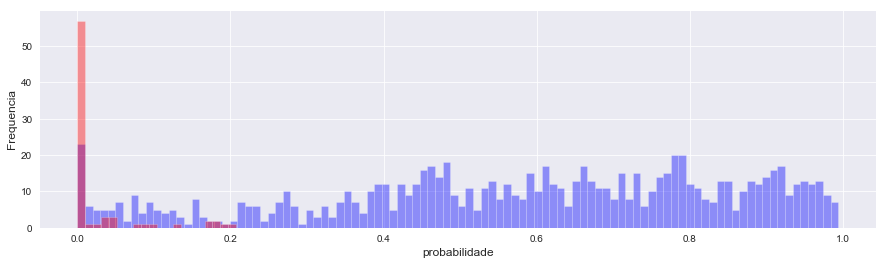

In [63]:
fig = plt.figure(figsize=(15,4),)
ax=sns.distplot(df_gauss_pca.loc[(df_gauss_pca['label'] == 'n'),'value'] , color='b',label='normal', kde = False,  bins = 100)
ax=sns.distplot(df_gauss_pca.loc[(df_gauss_pca['label'] == 'o'),'value'] , color='r', label='outlier', kde = False,  bins = 20)
ax.set(xlabel='probabilidade', ylabel='Frequencia')

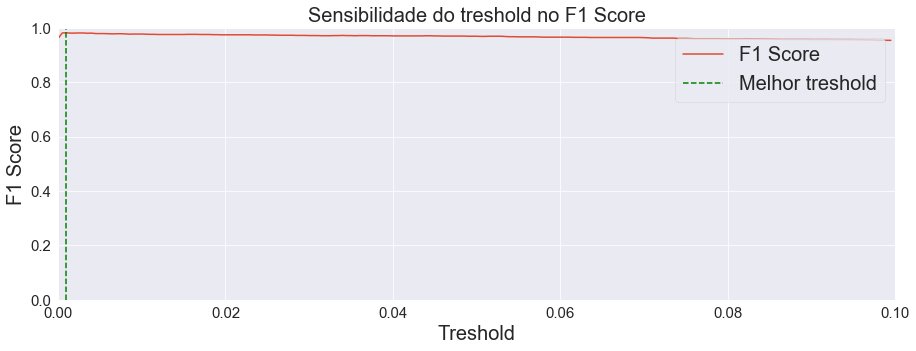

valor máximo de F1: 98.231%


0.001

In [64]:
f1_treshold(np.where(df_gauss_pca['label'] == 'o' , 0, 1), df_gauss_pca['value'], 0.0005, min_ = 0, max_ = 0.1)

In [86]:
# se o evento tem probabilidade menor que 0.2% de acontecer, é uma falha
df_gauss_pca['pred'] = np.where(df_gauss_pca['value'] < 0.08 , 0, 1)
#df_gauss['label'] = np.where(df_gauss['label'] == 'o' , 0, 1)

C_pca = confusion_matrix(np.where(df_gauss_pca['label'] == 'o' , 0, 1), df_gauss_pca['pred'])
f1_pca = f1_score(np.where(df_gauss_pca['label'] == 'o' , 0, 1), df_gauss_pca['pred'] )*100
print (C_pca)
print('')
print('F1 score: {:.3f} %'.format(f1_pca ))

[[ 65  10]
 [ 62 863]]

F1 score: 95.996 %


## Cluster PCA

Faz uma clusterização do dataset PCA em dois grupos, utilizando a distância de mahalanobis, para ver se o método consegue capturar a existencia de dois grupos no dataset (normal e outlier)

In [69]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances

X = df_pca[['pca_1','pca_2','pca_3','pca_4','pca_5']]

m = pairwise_distances(X, X, metric='mahalanobis')

agg = AgglomerativeClustering(n_clusters=2, affinity='precomputed',
                              linkage='complete')

u = agg.fit_predict(m)


In [70]:
u

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [71]:
df_pca_cluster = pd.DataFrame({
    'label':np.where(df_pca['label'] == 'o' , 1, 0),
    'predict': list(u) 
             })

#df_pca_cluster['label'] = abs(df_pca_cluster['label'] - 1)
#df_pca_cluster['predict'] = abs(df_pca_cluster['predict'] - 1)

df_pca_cluster.head()

,label,predict
0,1,1
1,1,1
2,1,0
3,1,0
4,1,1


In [91]:
C_clust_pca = confusion_matrix(df_pca_cluster['label'], 
                    df_pca_cluster['predict'] )
f1_clust_pca = f1_score(df_pca_cluster['label'],df_pca_cluster['predict']  )*100
print (C_clust_pca)
print('F1 score: {:.3f} %'.format( f1_clust_pca))

[[5023    2]
 [  40   35]]
F1 score: 62.500 %


## Cluster todas as variaveis

In [74]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances

X = df[var_cols]

m = pairwise_distances(X, X, metric='mahalanobis')

agg = AgglomerativeClustering(n_clusters=2, affinity='precomputed',
                              linkage='complete')

u = agg.fit_predict(m)


In [77]:
df_cluster = pd.DataFrame({
    'label':np.where(df['anomaly'] == 'o' , 1, 0),
    'predict': list(u) 
             })

#df_pca_cluster['label'] = abs(df_pca_cluster['label'] - 1)
#df_pca_cluster['predict'] = abs(df_pca_cluster['predict'] - 1)

df_cluster.head()

,label,predict
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [89]:
C_clust = confusion_matrix(df_cluster['label'], 
                    df_cluster['predict'] )
f1_clust = f1_score(df_cluster['predict'], df_cluster['label']  )*100

print (C_clust)
print('F1 score: {:.3f} %'.format(f1_clust ))

[[4999   26]
 [  73    2]]
F1 score: 3.883 %


In [96]:
print('F1 scores:')
print('Normal multivariada dataset original {:.2f}%'.format(f1_orig*100))
print('Normal multivariada dataset PCA      {:.2f}%'.format(f1_pca))
print('Clusterização dataset original       {:.2f}%'.format(f1_clust))
print('Clusterização dataset PCA            {:.2f}%'.format(f1_clust_pca))

F1 scores:
Normal multivariada dataset original 97.00%
Normal multivariada dataset PCA      96.00%
Clusterização dataset original       3.88%
Clusterização dataset PCA            62.50%
